# Exploring the concept of Grad-CAM heatmaps for the DHEIVER/Alzheimer-MRI

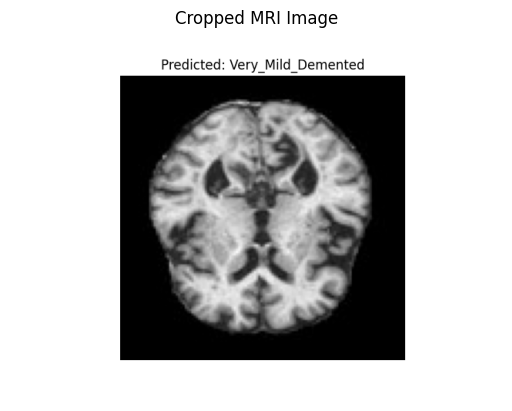

In [30]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# Load your image
img = Image.open("/Users/timoturnley/Downloads/image.png")  # Replace with actual path

# Convert to grayscale and get bounding box of content
gray = ImageOps.grayscale(img)
bbox = gray.getbbox()  # Finds non-black region

# Crop image to content area
cropped_img = img.crop(bbox)

# Show cropped result
plt.imshow(cropped_img)
plt.axis("off")
plt.title("Cropped MRI Image")
plt.show()

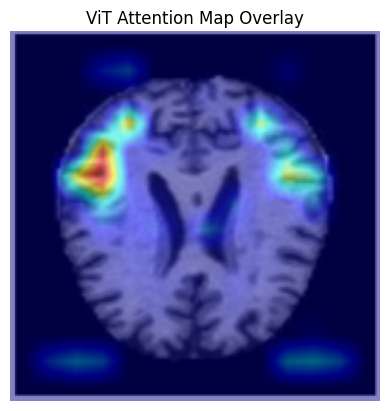

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForImageClassification, AutoImageProcessor
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import cv2

# === Step 1: Load model and processor ===
model_id = "DHEIVER/Alzheimer-MRI"
model = AutoModelForImageClassification.from_pretrained(model_id, output_attentions=True)
processor = AutoImageProcessor.from_pretrained(model_id)
model.eval()

# === Step 2: Load and preprocess MRI image ===
image = Image.open("/Users/timoturnley/Documents/Screenshot 2025-08-02 at 18.09.51.png").convert("RGB")  # update path
inputs = processor(images=image, return_tensors="pt")

# === Step 3: Forward pass with attention outputs ===
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

# === Step 4: Extract last layer attention (avg over heads) ===
attentions = torch.stack(outputs.attentions)            # shape: (layers, batch, heads, tokens, tokens)
last_layer_attn = attentions[-1][0]                     # shape: (heads, tokens, tokens)
avg_attn = last_layer_attn.mean(0)                      # shape: (tokens, tokens)
cls_attn = avg_attn[0, 1:]                              # attention from CLS token to all patches
cls_attn_map = cls_attn.reshape(14, 14).cpu().numpy()   # reshape to patch grid

# === Step 5: Normalize and resize to image size ===
attn_resized = cv2.resize(cls_attn_map, (224, 224))
attn_resized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min())

# === Step 6: Overlay on original image ===
image_np = np.array(image.resize((224, 224))).astype(np.float32) / 255.0
overlay = show_cam_on_image(image_np, attn_resized, use_rgb=True)

# === Step 7: Display ===
plt.imshow(overlay)
plt.axis("off")
plt.title("ViT Attention Map Overlay")
plt.show()

* The model relies on the left temporal-parietal region, area well known for early site of degeneratoion in Alzheimers. 
* An attention map is visual explanation of the image the model considered important for making its decision. 
* Critical for building trust with medical professionals - seeing that the model looks in the right place gives clinicians confidence.
* 